In [1]:
!pip install spacy
!python -m spacy download ru_core_news_lg

You should consider upgrading via the 'C:\Users\Dmitry\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


     -------------------------------------- 514.5/514.5 MB 2.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')


You should consider upgrading via the 'C:\Users\Dmitry\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


# Кластеризация текста

## Загрузка данных

In [2]:
import re
import time
import os.path
import warnings

from tqdm import tqdm
from collections import Counter, OrderedDict

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
import spacy
from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import silhouette_score


warnings.filterwarnings('ignore')
nltk.download('stopwords')

nlp = spacy.load("ru_core_news_sm")
parent_dir = os.path.dirname(os.getcwd())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
posts_df = pd.read_csv(os.path.join(parent_dir, "datasets/posts.csv"))
posts_df.iloc[11]

id                                                   1631877
text       С раннего детства я очень остро реагирую на ра...
likes                                                   1289
reposts                                                   95
views                                                 125185
Name: 11, dtype: object

In [4]:
posts_df.iloc[11]["text"]

'С раннего детства я очень остро реагирую на распускание рук. Как пелена опускалась, дыхание перехватывало и я уже думала только о том, как отомстить. Поэтому бабушка быстро оставила попытки "воспитания" ремнем, когда я тем же ремнем со всей силы ударила ее спящую. Помню, как начала лупить линейкой учительницу в первом классе, которая нас била по рукам за исправления... Вообще считаю, что дети, которых в детстве били родители, имеют право избивать их беспомощных в старости.\r\n\r\n#Подслушано_жестокость@overhear'

In [5]:
posts_df["tag"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[-1].replace("\r\n\r\n#", "") if len(str(x).split("Подслушано")) > 1 else None)
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).split("Подслушано")[0])

In [6]:
posts_df.iloc[10:15]["text"].tolist()

['Ничто не поднимает настроение лучше, чем тот факт, что моя бывшая через год после расставания уже успела в 21 год по залету выйти замуж и родить ребенка. Прям злодейски смеяться хочется от этого!\r\n\r\n#',
 'С раннего детства я очень остро реагирую на распускание рук. Как пелена опускалась, дыхание перехватывало и я уже думала только о том, как отомстить. Поэтому бабушка быстро оставила попытки "воспитания" ремнем, когда я тем же ремнем со всей силы ударила ее спящую. Помню, как начала лупить линейкой учительницу в первом классе, которая нас била по рукам за исправления... Вообще считаю, что дети, которых в детстве били родители, имеют право избивать их беспомощных в старости.\r\n\r\n#',
 'Ненавижу убираться, когда все дома. Тут же налетает вся семья и оказывается, что весь мусор — очень нужный мусор. Зато если выбросить, когда никто не видит, то даже не заметят!',
 'Когда мне было 10, умерла бабушка. Она на тот момент лежала в больнице, поэтому печальную новость нам сообщили, позво

In [7]:
posts_df["tag"] = posts_df["tag"].apply(lambda x: str(x).replace("@overhear", "").replace("\r", "").replace("\n", " ").replace("_", ""))
posts_df["text"] = posts_df["text"].apply(lambda x: str(x).replace("\r", "").replace("\n", " ").replace("\t", " "))
posts_df.head()

,id,text,likes,reposts,views,tag
0,1632037,Однажды делал своей девушке куни. В самый моме...,19,34,5518,пошлое
1,1632031,Живу с молодым человеком и его мамой (временна...,369,64,53145,провал
2,1632022,"Всегда презирала проституток, порноактрис. А п...",167,47,27266,None
3,1632004,"Подруга полгода пролежала в коме после аварии,...",307,184,71438,пиздец
4,1631999,"Когда вернулся из армии, моя бабушка умерла и ...",820,9,97900,успех


<AxesSubplot:xlabel='word number', ylabel='Density'>

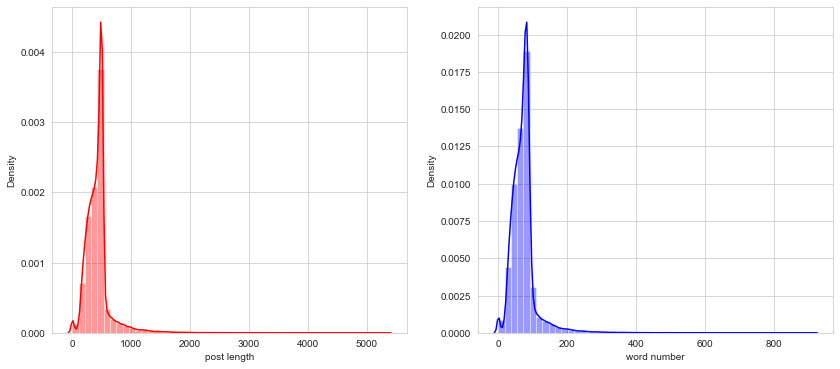

In [8]:
train_len = posts_df["text"].apply(len).rename("post length")
train_count = posts_df["text"].apply(lambda row: len(str(row).split(" "))).rename("word number")
fig=plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
sns.distplot(train_len,color='red')
fig.add_subplot(1,2,2)
sns.distplot(train_count,color='blue')

In [9]:
posts_df.nunique()

id         87994
text       87117
likes      20461
reposts     1378
views      78203
tag          202
dtype: int64

In [10]:
document = " ".join(posts_df["text"].to_list())

In [11]:
document[8990:9100]

'на 2 года старше. Отношения у нас продолжались до моих 17 лет. Налево бегала от него, дурочка. Такой взрослой '

(-0.5, 799.5, 599.5, -0.5)

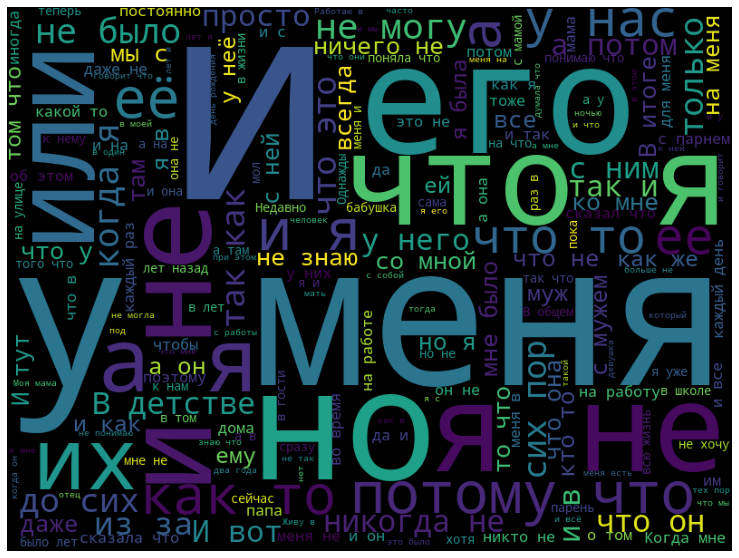

In [12]:
cloud = WordCloud(width=800, height=600, stopwords=set(STOPWORDS)).generate(document)
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Очистка данных

In [13]:
def clean_data(text: str) -> str:
    """Очистка данных."""
    letters_only = re.sub("[^а-яА-Я]", " ", text)
    lowercase_text = letters_only.lower()
    stemmer = RussianStemmer()
    stemmer_no_stop_words = []
    for word in lowercase_text.split():
        if word not in set(stopwords.words("russian")):
            stemmer_no_stop_words.append(stemmer.stem(word))
    return " ".join(stemmer_no_stop_words)

In [14]:
clear_posts_df = posts_df.copy()

In [15]:
clear_posts_df["text"] = clear_posts_df["text"].apply(clean_data)

In [16]:
clear_posts_df.head()

,id,text,likes,reposts,views,tag
0,1632037,однажд дела сво девушк кун сам момент оргазм в...,19,34,5518,пошлое
1,1632031,жив молод человек мам времен мер уезжа недельк...,369,64,53145,провал
2,1632022,презира проституток порноактрис сам анус мужск...,167,47,27266,None
3,1632004,подруг полгод пролежа ком авар потихоньк прихо...,307,184,71438,пиздец
4,1631999,вернул арм бабушк умерл остав квартир поступ м...,820,9,97900,успех


In [17]:
clear_posts_df.to_csv(os.path.join(parent_dir, "datasets/clear_posts.csv"), index=False)

In [18]:
clear_document = " ".join(clear_posts_df["text"].to_list())
clear_document[1000:2000]

'ом двухлетн дочк пок говор заплака иб рад жив вернул арм бабушк умерл остав квартир поступ москв контрактн основ секунд дум прода квартир поеха уч мног открыт говор дурак обменя квартир корочк спуст лет смог куп дом столиц правд сво профил работа врем студенчеств друг нача бизнес получа отличн доход рискнул прода квартир сидел дальш хож цел стен дом молод человек ко приеха настро душевн физическ инт пропада правильн настроен реш глянут порн давн смотрел включ сраз категор котор моментальн довод оргазм оргазм хвата вспомн понрав ролик категор красив секс нашл нечт подобн душевн рождественск секс конц ролик дар друг друг подарочк смеют расплака работа секретар м институт стол сто мфу принтер сканер ксерокс бес усрачк сотрудник постоя ход ко распечатыва дают занима мо работ практическ вс сво врем трач распечатыван сканирован всяк херн вмест дела поруч начальник понима принос распечатк документ институт паспорт справк свидетельств вс ответ эт ваш деньг тяж ло детств сих пор сжима сердц сл

(-0.5, 799.5, 599.5, -0.5)

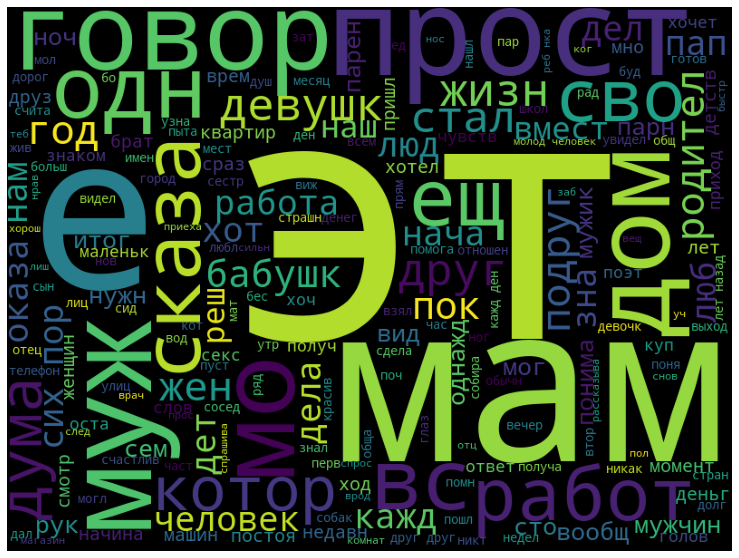

In [19]:
cloud = WordCloud(width=800, height=600, stopwords=set(stopwords.words("russian"))).generate(clear_document)
plt.figure(figsize=(16,10))
plt.imshow(cloud)
plt.axis('off')

## Анализ данных

In [20]:
for w in nlp(clear_document[100:200]):
    print(w.text, w.pos_)

олов NOUN
зап PROPN
жив ADJ
молод PROPN
человек NOUN
мам NOUN
времен NOUN
мер NOUN
уезжа NOUN
недельк VERB
родн ADJ
город NOUN
вернул VERB
аккурат NOUN
эт PROPN
врем NUM
нача NOUN
крити NOUN


In [21]:
len(clear_document) / nlp.max_length

21.966774

Будем разбивать наш текст для обработки на 37 частей

In [22]:
document_chunk = [clear_document[i:i+nlp.max_length] for i in range (0,len(clear_document), nlp.max_length)]

In [23]:
len(document_chunk[0])

1000000

Проанализируем каждый чанк

In [24]:
docs = []
for doc_chunk in tqdm(document_chunk):
    doc = nlp(doc_chunk)
    docs.append(doc)

100%|██████████| 22/22 [36:06<00:00, 98.48s/it]


Теперь из текстового документа можно найти существительные и глаголы.

Среди существительных выделить персон и организации.

In [25]:
words = []
nouns = []
verbs = []
people = []
orgs = []

In [26]:
for doc in tqdm(docs):
    for token in doc:
        if token.pos_ != 'SPACE' and token.pos_ != 'PUNCT':
            words.append(token.text)
        if token.pos_ == "VERB":
            verbs.append(token.text)

        if token.pos_ == "NOUN":
            nouns.append(token.text)

100%|██████████| 22/22 [00:04<00:00,  4.70it/s]


In [27]:
for doc in tqdm(docs):
    for ent in doc.ents:
        if ent.label_ == "ORG":
            orgs.append(ent.text)
        if ent.label_ == "PERSON":
            people.append(ent.text)

100%|██████████| 22/22 [00:00<00:00, 32.48it/s]


In [28]:
print("Всего слов: ", len(words))
print("Всего глаголов: ", len(verbs))
print("Всего существительных: ", len(nouns))
print("Всего людей: ", len(people))
print("Всего организаций: ", len(orgs))

Всего слов:  3690333
Всего глаголов:  474464
Всего существительных:  1832427
Всего людей:  0
Всего организаций:  62897


In [29]:
print("Пример слова: ", words[100])
print("Пример глагола: ", verbs[20])
print("Пример существительного: ", nouns[10])
print("Пример организации: ", orgs[0])

Пример слова:  презира
Пример глагола:  вернул
Пример существительного:  голов
Пример организации:  сво


Определим частоту слов

In [30]:
def sort_by_frequency(data,reverse = True):
    """Сортировка данных по их частоте"""
    data_with_freq = dict(Counter(data))
    data_sorted_by_freq = OrderedDict(sorted(data_with_freq.items(), key=lambda x: x[1],reverse=reverse))

    return data_sorted_by_freq

In [31]:
words_freq = sort_by_frequency(words)
nouns_freq = sort_by_frequency(nouns)
verbs_freq = sort_by_frequency(verbs)
people_freq = sort_by_frequency(people)
orgs_freq = sort_by_frequency(orgs)

Рассмотрим наиболее частые слова

In [32]:
list(words_freq)[0:10]

['эт', 'лет', 'мо', 'котор', 'сво', 'дом', 'мам', 'муж', 'очен', 'сам']

Как можно наблюдать, наиболее частые слова - это предлоги, союзы, местоимения.

Рассмотрим наиболее частые существительные

In [33]:
list(nouns_freq)[0:10]

['лет',
 'дом',
 'муж',
 'мам',
 'год',
 'котор',
 'работ',
 'сказа',
 'говор',
 'работа']

Рассмотрим наиболее частые глаголы

In [34]:
list(verbs_freq)[0:10]

['одн',
 'девушк',
 'стал',
 'сво',
 'родител',
 'мог',
 'бабушк',
 'хотел',
 'жил',
 'хочет']

Рассмотрим наиболее частых персон

In [35]:
list(people_freq)[0:10]

[]

Рассмотрим наиболее частые организации

In [36]:
list(orgs_freq)[0:10]

['вс', 'мо', 'сво', 'еха', 'нка', 'нов', 'упа', 'вещ', 'общ', 'ве']

## Анализ N-грамм

In [37]:
def create_bigram(tokens: list) -> list:
    """Создание биграмм на основе токенов."""
    _bigrams = nltk.bigrams(tokens)
    return list(_bigrams)

In [38]:
bigrams_list = create_bigram(words)
bigrams = [" ".join(bigram) for bigram in list(bigrams_list)]

In [39]:
bigrams[100:110]

['презира проституток',
 'проституток порноактрис',
 'порноактрис сам',
 'сам анус',
 'анус мужск',
 'мужск лиза',
 'лиза камер',
 'камер соса',
 'соса старик',
 'старик орг']

Сортировка биграмм по частоте встречи

In [40]:
bigram_frequency = sort_by_frequency(bigrams)

Мы можем наблюдать частоту встречи биграмм

In [41]:
def get_top_n_from_order_dict(ordered_dict: OrderedDict,n: int) -> list:
    """Нахождение первых n-элементов из order dict."""
    return [list(ordered_dict.items())[i] for i in range(n)]

In [42]:
top_bigram = get_top_n_from_order_dict(bigram_frequency,25)

In [43]:
top_bigram

[('сих пор', 4449),
 ('друг друг', 2701),
 ('кажд ден', 2055),
 ('лет назад', 1870),
 ('молод человек', 1864),
 ('реб нка', 1757),
 ('тех пор', 1451),
 ('реб нок', 1364),
 ('ден рожден', 1331),
 ('год назад', 1312),
 ('эт врем', 1311),
 ('нескольк лет', 1302),
 ('пят лет', 1210),
 ('жив т', 1147),
 ('след ден', 1139),
 ('вс эт', 1110),
 ('нов год', 1076),
 ('вышл замуж', 1054),
 ('мо жизн', 1048),
 ('люд котор', 987),
 ('уш л', 976),
 ('жив м', 963),
 ('вс равн', 960),
 ('мо родител', 960),
 ('приш л', 950)]

In [44]:
def visualize_list_of_tuple(data):
    """Визуализация списка кортежей."""
    list1, list2 = zip(*data)
    y_pos = np.arange(len(list1))
    plt.barh(y_pos, list2, align='center', alpha=0.5)
    plt.yticks(y_pos, list1)
    plt.show()

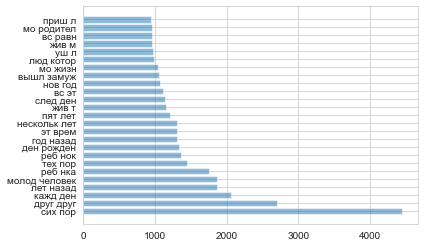

In [45]:
visualize_list_of_tuple(top_bigram)

Поиск уникальных существительных, глаголов, персон и организаций

In [46]:
unique_nouns = set(nouns)
unique_verbs = set(verbs)
unique_people = set(people)
unique_orgs = set(orgs)

Создадим биграммы с двумя существительными

In [47]:
def get_noun_noun_bigram(bigrams):
    """Поиск биграмм с двумя существительными."""
    NN_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_nouns and second_word in unique_nouns:
            NN_bigrams.append(" ".join((first_word,second_word)))
    return NN_bigrams
NN_bigrams = get_noun_noun_bigram(bigrams_list)

In [48]:
NN_bigrams[100:120]

['ник осужда',
 'осужда бо',
 'бо дела',
 'дела эт',
 'эт подруг',
 'подруг полгод',
 'полгод пролежа',
 'пролежа ком',
 'ком авар',
 'авар потихоньк',
 'потихоньк приход',
 'приход недавн',
 'недавн обрывист',
 'обрывист слов',
 'слов благодар',
 'благодар помогл',
 'помогл е',
 'е сем',
 'сем смотрел',
 'смотрел маленьк']

Рассмотрим биграммы, где первым словом является глагол

In [49]:
def get_bigram_starting_with_verb(bigrams):
    """Выдать список биграмм, начинающихся с глагола."""
    V_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_verbs:
            V_bigrams.append(" ".join((first_word,second_word)))

    return V_bigrams
V_bigrams = get_bigram_starting_with_verb(bigrams_list)

In [50]:
V_bigrams[100:120]

['настроен реш',
 'реш глянут',
 'глянут порн',
 'порн давн',
 'давн смотрел',
 'смотрел включ',
 'включ сраз',
 'моментальн довод',
 'оргазм оргазм',
 'оргазм хвата',
 'вспомн понрав',
 'понрав ролик',
 'красив секс',
 'секс нашл',
 'секс конц',
 'конц ролик',
 'смеют расплака',
 'м институт',
 'стол сто',
 'сто мфу']

Первое слово в биграмме организация

In [51]:
def get_bigram_starting_with_organization(bigrams):
    """Выдать биграммы, начинающиеся с организации."""
    org_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_orgs:
            org_bigrams.append(" ".join((first_word,second_word)))
    return org_bigrams
org_bigrams = get_bigram_starting_with_organization(bigrams_list)

In [52]:
org_bigrams[100:120]

['еха маршрутк',
 'выпа подкат',
 'мо ног',
 'вс прекрасн',
 'эт дума',
 'ден вернувш',
 'мо вещ',
 'вещ сумк',
 'либ либ',
 'либ ключ',
 'утр москв',
 'москв аэропорт',
 'сиж пью',
 'коф вылет',
 'сид женщин',
 'эт понима',
 'эт нача',
 'ден мат',
 'мат мозол',
 'куч лишн']

Первое слово персона

In [53]:
def get_bigram_starting_with_person(bigrams):
    people_bigrams = []
    for first_word,second_word in bigrams:
        if first_word in unique_people:
            people_bigrams.append(" ".join((first_word,second_word)))
    return people_bigrams
people_bigrams = get_bigram_starting_with_person(bigrams_list)

In [54]:
people_bigrams

[]

Сортировка по частоте слов

In [55]:
NN_bigrams_frequency = sort_by_frequency(NN_bigrams)
V_bigrams_frequency  = sort_by_frequency(V_bigrams)
people_bigrams_frequency = sort_by_frequency(people_bigrams)
org_bigrams_frequency = sort_by_frequency(org_bigrams)

In [56]:
list(NN_bigrams_frequency)[50:100]

['эт очен',
 'дн м',
 'друг город',
 'сво жизн',
 'эт прост',
 'эт дела',
 'дво дет',
 'мо подруг',
 'парн котор',
 'пар месяц',
 'тр х',
 'последн врем',
 'сказа эт',
 'поня эт',
 'зна эт',
 'мо м',
 'лучш друг',
 'сво дел',
 'сем й',
 'мужчин котор',
 'прошл год',
 'бабушк дедушк',
 'понима поч',
 'мо бабушк',
 'вс м',
 'лет пят',
 'некотор врем',
 'сво м',
 'дела эт',
 'сл зы',
 'подош л',
 'жд т',
 'занима секс',
 'старш брат',
 'нача встреча',
 'мам пап',
 'бывш муж',
 'мо парн',
 'час ноч',
 'ш л',
 'сч т',
 'т д',
 'полтор год',
 'спуст год',
 'кажд год',
 'сво парн',
 'младш брат',
 'заш л',
 'старш сестр',
 'недавн узна']

In [57]:
list(V_bigrams_frequency)[50:100]

['сво дел',
 'сем й',
 'бабушк дедушк',
 'мо бабушк',
 'вс м',
 'сво м',
 'подош л',
 'жд т',
 'мам пап',
 'бывш муж',
 'мо парн',
 'ш л',
 'очен хотел',
 'спуст год',
 'кажд год',
 'сво парн',
 'заш л',
 'недавн узна',
 'сво дет',
 'мам сказа',
 'сво муж',
 'восем лет',
 'кажд утр',
 'очен красив',
 'эт мо',
 'мог поня',
 'перв этаж',
 'вдво м',
 'личн жизн',
 'прош л',
 'реб нку',
 'мам говор',
 'подруг котор',
 'сдела предложен',
 'эт сдела',
 'спуст лет',
 'кажд вечер',
 'обраща вниман',
 'куп квартир',
 'мо друз',
 'познаком парн',
 'возвраща дом',
 'эт дел',
 'пришл дом',
 'п т',
 'врем секс',
 'зна дела',
 'ч рны',
 'бес люд',
 'ещ одн']

In [58]:
list(people_bigrams_frequency)[50:100]

[]

In [59]:
list(org_bigrams_frequency)[50:100]

['мам сказа',
 'сво муж',
 'эт мо',
 'реб нку',
 'мам говор',
 'эт сдела',
 'куп квартир',
 'пар недел',
 'мо друз',
 'эт дел',
 'зна дела',
 'ч рны',
 'сер зно',
 'ещ одн',
 'пят минут',
 'мо детств',
 'вс ещ',
 'цел ден',
 'мо отц',
 'мо любим',
 'пар минут',
 'мо знаком',
 'эт так',
 'реш сдела',
 'ран утр',
 'мам очен',
 'мо сем',
 'тро дет',
 'ч рт',
 'сво сем',
 'мо сестр',
 'мо голов',
 'мо рук',
 'сво квартир',
 'пар час',
 'ост тся',
 'ве вечер',
 'куп нов',
 'сво врем',
 'нов работ',
 'жит вмест',
 'эт лет',
 'мо бывш',
 'втро м',
 'мам работа',
 'зна поч',
 'мо брат',
 'ид м',
 'эт лучш',
 'мам эт']

Топ 25 биграмм с двумя существительными

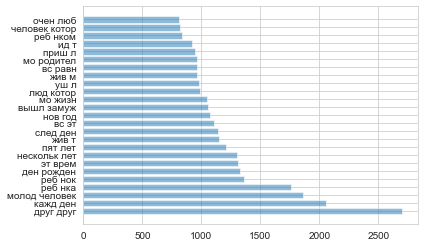

In [60]:
top_25_NN_bigram = get_top_n_from_order_dict(NN_bigrams_frequency,25)
visualize_list_of_tuple(top_25_NN_bigram)

## Кластеризация документов

Очистим документ перед кластеризацией

In [61]:
cleaned_documents = clear_posts_df["text"].to_list()

In [62]:
class DocumentCluster:
    """Определение кластера докуманта."""
    def __init__(self,model,data):
        self.model = model
        self.data = data
        self.model_name = self._get_model_name()

        self.cluster_pipeline = None

    def _get_model_name(self):
        """Выдать название, используемой модели."""
        model_name = str(self.model).split('(')[0]
        return model_name

    def train_model(self,ngram: int,use_idf: bool):
        """Обучение модели."""
        current_time = time.time()

        self.cluster_pipeline = Pipeline([
            ('vect', CountVectorizer(ngram_range=(1,ngram), analyzer="word")),
            ('tfidf', TfidfTransformer(use_idf=use_idf)),
            ('model', self.model),
        ])
        self.cluster_pipeline.fit(self.data)
        train_time = time.time() - current_time

        print("Обучение модели завершено.")
        print(f"Модель {self.model_name} : {train_time} сек.")


    def predict(self):
        """Выдать кластер id."""
        self.document_id_dict = {}
        self.cluster_id = []
        for document in tqdm(self.data):
            cluster_id = self.cluster_pipeline.predict([document])[0]
            self.document_id_dict.update({document:cluster_id})
            self.cluster_id.append(cluster_id)

        return self.document_id_dict

Используем модель K-средних с 3 кластерами

In [63]:
cluster_num = 3

In [64]:
model = KMeans(n_clusters=cluster_num, init = "k-means++",max_iter=150, n_init=1)

In [65]:
doc_cluster = DocumentCluster(data=cleaned_documents, model=model)

In [66]:
doc_cluster.train_model(ngram=2, use_idf=True)

Обучение модели завершено.
Модель KMeans : 60.994975566864014 сек.


In [67]:
result_docs = doc_cluster.predict()

100%|██████████| 87994/87994 [1:12:57<00:00, 20.10it/s]


In [68]:
clusters_text = []
for i in tqdm(range(cluster_num)):
    text = " ".join([k for k,v in result_docs.items() if v == i])
    clusters_text.append(text)

100%|██████████| 3/3 [00:00<00:00, 21.13it/s]


In [69]:
doc_cluster.cluster_id[0:20]

[2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2]

In [77]:
len(doc_cluster.cluster_id)

87994

In [80]:
clustering_results = posts_df[["id"]]
clustering_results["cluster"] = doc_cluster.cluster_id
clustering_results.head()
clustering_results.to_csv(os.path.join(parent_dir, "results/clustering.csv"), index=False)

In [ ]:
results = []
for k in range(1, 6):
    m = KMeans(n_clusters=k, init = "k-means++",max_iter=150, n_init=1)
    doc_cluster_ = DocumentCluster(data=cleaned_documents, model=model)
    doc_cluster_.train_model(ngram=2, use_idf=True)
    labels = doc_cluster_.predict()
    results.append({"clusters": k, "silhouette_score": silhouette_score(cleaned_documents, labels)})

Анализ биграмм всех кластеров

Возьмем так же первые 25 биграмм каждого кластера

In [72]:
def get_cluster_analysis_results(cluster_text: list):
    """Выдать результаты кластерного анализа."""
    clusters = {}

    for i, text in tqdm(enumerate(cluster_text)):
        if text == 'nan':
            continue
        tokens = text.split()
        # Используя токены слов, найдем биграммы
        bigram_list = create_bigram(tokens)
        bigrams = [" ".join(bigram) for bigram in list(bigram_list)]
        bigram_frequency = sort_by_frequency(bigrams)
        top_bigrams = get_top_n_from_order_dict(bigram_frequency,25)

        # Ищем биграммы с двумя существительными
        NN_bigrams = get_noun_noun_bigram(bigram_list)
        NN_bigrams_frequency = sort_by_frequency(NN_bigrams)
        top_NN_bigrams = get_top_n_from_order_dict(NN_bigrams_frequency,25)

        # Ищем биграммы, начиная с глагола
        V_bigrams = get_bigram_starting_with_verb(bigram_list)
        V_bigrams_frequency = sort_by_frequency(V_bigrams)
        top_V_bigrams = get_top_n_from_order_dict(V_bigrams_frequency,25)

        # # Ищем биграммы с персоной
        # people_bigrams = get_bigram_starting_with_person(bigram_list)
        # people_bigrams_frequency = sort_by_frequency(people_bigrams)
        # top_people_bigrams = get_top_n_from_order_dict(people_bigrams_frequency,25)

        # # Поиск биграмм с организацией
        # org_bigrams = get_bigram_starting_with_organization(bigram_list)
        # org_bigrams_frequency = sort_by_frequency(org_bigrams)
        # top_org_bigrams = get_top_n_from_order_dict(org_bigrams_frequency,25)


        cluster_analysis_result = {
            "bigram_freq":top_bigrams,
            "noun_noun_bigram":top_NN_bigrams,
            "verb_bigram":top_V_bigrams,
            # "people_bigram": top_people_bigrams,
            # "organization_bigram":top_org_bigrams,
        }
        clusters.update({i:cluster_analysis_result})
    return clusters

In [73]:
all_clusters = get_cluster_analysis_results(clusters_text)

3it [00:45, 15.27s/it]


Сравним различные биграммы из разных кластеров

In [74]:
def compare_bigram_of_clusters(comparision_parameter):
    """Создаем сравнительный DataFrame."""
    cluster_data = {}
    for cluster_id in tqdm(range(cluster_num)):
        try:
            cluster_result = all_clusters[cluster_id]
            data = cluster_result[comparision_parameter]
            bigram, frequency = zip(*data)
            col1 = "bigram_cluster_" + str(cluster_id)
            col2 = "bigram_freq_cluster_" + str(cluster_id)
            cluster_data.update({col1:bigram, col2: frequency})
        except:
            continue
    return pd.DataFrame(data=cluster_data)

In [75]:
df = compare_bigram_of_clusters("bigram_freq")
df

100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]


,bigram_cluster_0,bigram_freq_cluster_0,bigram_cluster_1,bigram_freq_cluster_1,bigram_cluster_2,bigram_freq_cluster_2
0,друг друг,2340,сих пор,1133,сих пор,2170
1,сих пор,1145,мо мам,633,кажд ден,1114
2,реб нка,1143,мам пап,387,молод человек,927
3,лет назад,876,мо родител,380,тех пор,813
4,молод человек,818,мам сказа,315,люд котор,740
5,вышл замуж,789,лет мам,301,лет назад,708
6,год назад,781,ден рожден,297,ид т,677
7,реб нок,725,мам говор,294,след ден,657
8,кажд ден,682,тех пор,290,ден рожден,567
9,мо жизн,642,лет назад,285,приш л,559


In [76]:
df = compare_bigram_of_clusters("noun_noun_bigram")
df

100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


,bigram_cluster_0,bigram_freq_cluster_0,bigram_cluster_1,bigram_freq_cluster_1,bigram_cluster_2,bigram_freq_cluster_2
0,друг друг,2340,мо мам,633,кажд ден,1114
1,реб нка,1143,мам пап,387,молод человек,927
2,молод человек,818,мо родител,380,люд котор,740
3,вышл замуж,789,мам сказа,315,ид т,677
4,реб нок,725,лет мам,301,след ден,657
5,кажд ден,682,ден рожден,297,ден рожден,567
6,мо жизн,642,мам говор,294,приш л,559
7,нескольк лет,632,реб нка,270,эт врем,540
8,пят лет,623,кажд ден,259,пош л,508
9,эт врем,592,реб нок,254,вс эт,502
